In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import plotly
import os
print(os.getcwd())

/home/savvyfox/Projects/safe-control-gym/examples/rl


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, mode='valid')
    
def load_from_log_file(path):
    '''Return x, y sequence data from the stat csv.'''
    with open(path, 'r') as f:
        lines = f.readlines()
    # Labels.
    xk, yk = [k.strip() for k in lines[0].strip().split(',')]
    # Values.
    x, y = [], []
    for line in lines[1:]:
        data = line.strip().split(',')
        x.append(float(data[0].strip()))
        y.append(float(data[1].strip()))
    x = np.array(x)
    y = np.array(y)
    return xk, x, yk, y

In [32]:
seeds = [i for i in range(0,5)]
#seeds = [0]

data_paths = {
             # "PPO": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Longest_run/",
             #"PPO": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Long_run/", 
             # "PPO": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Long_run2/", 
            "PPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/exp_data/quadrotor_2D_attitude_ppo_data/",
            #"PPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/exp_data_T/quadrotor_2D_attitude_ppo_data/",
            #"PPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/exp_data_F/quadrotor_2D_attitude_ppo_data/",
            "PPO3": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/quadrotor_2D_attitude_ppo_data/PPO_ilqr_ref/",
            "PPO4": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/quadrotor_2D_attitude_ppo_data/PPO_ilqr_ref_woa/",
             # "PPO": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run/",
             # "ppo_22": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run2/",
             # "ppo_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Short_run/",
             # "ppo_4": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Shortest_run/",
             # "SAC": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Longest_run/",
             # "SAC": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Long_run/", 
             # "SAC": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Long_run2/", 
             # "SAC": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run/",
             # "sac_22": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run2/",
             # "sac_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Short_run/",
             # "sac_4": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Shortest_run/",
}

colors = {
    "PPO": "tab:orange",
    "PPO2": "tab:red",
    "PPO3": "tab:olive",
    "PPO4": "tab:cyan",
    "SAC": "tab:green",
    "GP MPC": "tab:blue",
    "iLQR": "tab:gray"
}

legends = {
    "PPO": "PPO",
    "PPO3": "PPO with ilqr ref",
    "PPO4": "PPO with ilqr state ref"
}

In [33]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    for seed in seeds:
        xk, x, lk, l = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({seed: {"x": x, "y": y, "z": z, "m": m, "n": n, "l": l}})

PPO
PPO3
PPO4


PPO
0.09238627995541378
PPO3
0.350353943509043
PPO4
0.17088204404413107


Text(0.5, 1.0, 'Task: Quadrotor 2D')

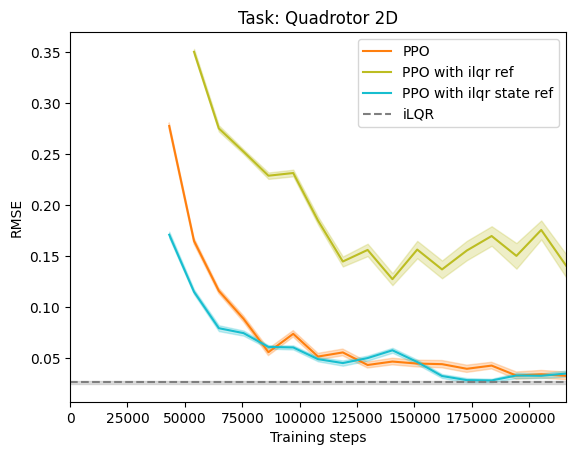

In [34]:
eval_data = {}
w = 1
fig = plt.figure()
last_iter = perf_data["PPO"][0]["x"][-1]
dummy = [0.15, 0.12]
for t, method in enumerate(data_paths.keys()):
    print(method)
    temp = np.zeros((len(seeds), 6, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        # print(seed)
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["m"]
        temp[seed, 4, :] = perf_data[method][seed]["n"]
        temp[seed, 5, :] = perf_data[method][seed]["l"]
    j_max = 0
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 540:
                temp[seed, 0, j] = np.nan
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
                if j >= j_max:
                    j_max = j+1
    eval_data.update({method: temp})
    start_iter = last_iter - perf_data[method][seed]["x"][-1]
    start_iter = 0

    # plotting performance
    # plt.plot(start_iter+temp[0,0,w-1:], moving_average(np.mean(temp[:,3,:], axis=0), w), label=method)
    # plt.fill_between(start_iter+temp[0,0,w-1:], 
    #                  moving_average(np.mean(temp[:,3,:], axis=0)-np.mean(temp[:,4,:], axis=0), w), 
    #                  moving_average(np.mean(temp[:,3,:], axis=0)+np.mean(temp[:,4,:], axis=0), w), alpha=0.25)
    plt.plot(start_iter+temp[0,0,:], np.mean(temp[:,3,:], axis=0), color=colors[method], label=legends[method])
    plt.fill_between(start_iter+temp[0,0,:], 
                     np.mean(temp[:,3,:]-temp[:,4,:], axis=0),  
                     np.mean(temp[:,3,:]+temp[:,4,:], axis=0), color=colors[method], alpha=0.25)
    print(np.mean(temp[:,3,j_max], axis=0))
    # plt.axhline(xmin=0.0, xmax=dummy[t], y=np.array(temp[:,3,j_max]).mean(), linestyle='-.', color='lightgray')

    # plotting constraint violations
    # plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)

# gp_mpc_data = np.load("./Results/LSY_pc/GPMPC_rmse_200_mass_20_sample_10_epoch.npy", allow_pickle=True).item()
# start_iter = last_iter - gp_mpc_data['train_steps'][-1]
# plt.plot(0*start_iter+gp_mpc_data['train_steps'], gp_mpc_data['mean'], color=colors["GP MPC"], label='GP MPC')
# plt.fill_between(0*start_iter+gp_mpc_data['train_steps'], 
#                  gp_mpc_data['mean']-gp_mpc_data['std'], 
#                  gp_mpc_data['mean']+gp_mpc_data['std'], color=colors["GP MPC"], alpha=0.25)

s = 1 # time std
rmse_ilqr_mean = 0.026000000000000002
rmse_ilqr_std = 0.001843908891458577
plt.axhline(xmin=0.0, xmax=1.0, y=rmse_ilqr_mean, linestyle='--', color=colors["iLQR"], label='iLQR')
plt.fill_between([0.0, last_iter], rmse_ilqr_mean-s*rmse_ilqr_std, rmse_ilqr_mean+s*rmse_ilqr_std, color=colors["iLQR"], alpha=0.25)


# real experiment data
# plt.plot(last_iter, 0.086, color=colors['PPO'], marker='x')
# plt.plot(last_iter, 0.064, color=colors['SAC'], marker='x')

plt.legend()
# plt.ylim(-200,00)
plt.xlim(0, 216000)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
# plt.text(900, 0.3, "Unssucessful evaluation runs", bbox=dict(facecolor='red', alpha=0.25))
plt.xlabel("Training steps")
plt.ylabel("RMSE")
plt.title("Task: Quadrotor 2D")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [42]:
metric = {}
noise_scale = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
for method in data_paths.keys():
    print(method)
    metric.update({method: {}})
    for seed in seeds:
        for ns in noise_scale:
            temp = np.load(data_paths[method] + str(seed) +"/metric_"+str(ns)+".npy", allow_pickle=True).item()
            if ns in metric[method].keys():
                metric[method][ns]['rmse'].append(temp['rmse'])
                metric[method][ns]['rmse_std'].append(temp['rmse_std'])
                temp2 = True if temp['average_length'] == 540.0 else False
                metric[method][ns]['success'].append(temp2)
            else:
                temp2 = True if temp['average_length'] == 540.0 else False
                metric[method].update({ns: {'rmse': [temp['rmse']], 
                                            'rmse_std': [temp['rmse_std']], 
                                            'success': [temp2]}})

PPO
SAC


In [20]:
metric

{'PPO': {1: {'rmse': [array([0.03954991, 0.02952318, 0.04092114, 0.02800149, 0.04400959,
           0.02662548, 0.02944364, 0.03904875, 0.02775426, 0.03511278]),
    array([0.04070723, 0.03145395, 0.04028517, 0.02766346, 0.0415407 ,
           0.02562376, 0.02981484, 0.03994833, 0.03090729, 0.03735818]),
    array([0.03145983, 0.01972989, 0.03287851, 0.01808824, 0.04164756,
           0.01953648, 0.01790794, 0.02994907, 0.01933651, 0.02548464]),
    array([0.04154148, 0.03171375, 0.04197975, 0.03146355, 0.05187719,
           0.03221417, 0.03158112, 0.04101934, 0.03301357, 0.03627831]),
    array([0.04409871, 0.03176296, 0.04428743, 0.02909585, 0.04595522,
           0.02921067, 0.03091882, 0.04329685, 0.03441138, 0.03782479])],
   'rmse_std': [0.006130261237096689,
    0.005736516148837012,
    0.007679949768696556,
    0.0063989610003052306,
    0.0064668992900339065]},
  10: {'rmse': [array([0.16413027, 0.15811217, 0.17252589, 0.17375992, 0.16505922,
           0.13834003, 0.1633480

True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Text(0.5, 1.0, 'PPO for Quadrotor 2D')

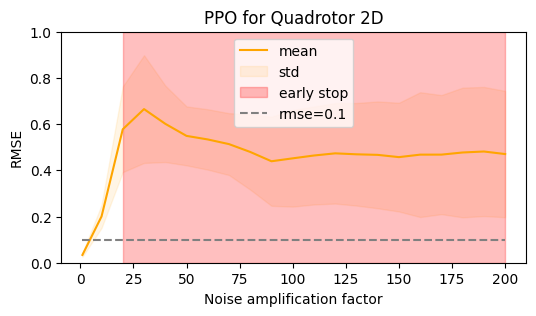

In [64]:
fig = plt.figure(figsize=(6, 3))
# for method in metric.keys():
method = 'PPO'
temp, temp_std1, temp_std2 = [], [], []
traj_success_till = 200
for ns in noise_scale:
    data = np.array(metric[method][ns]['rmse'])
    temp.append(data.mean())
    temp_std1.append(data.mean() - data.std())
    temp_std2.append(data.mean() + data.std())
    print(all(metric[method][ns]['success']))
    if not all(metric[method][ns]['success']) and traj_success_till > ns:
        traj_success_till = ns
plt.plot(noise_scale, temp, color=colors[method], label='mean')
plt.fill_between(noise_scale, 
                 temp_std1,  
                 temp_std2, color=colors[method], alpha=0.1, label='std')

plt.fill_between([traj_success_till, 200], [1, 1], color='r', alpha=0.25, label='early stop')
plt.plot(noise_scale, [0.1]*len(noise_scale), color='grey', linestyle='--', label='rmse=0.1')

plt.legend()
plt.ylim(0,1)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise amplification factor")
plt.ylabel("RMSE")
plt.title("PPO for Quadrotor 2D")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Text(0.5, 1.0, 'SAC for Quadrotor 2D')

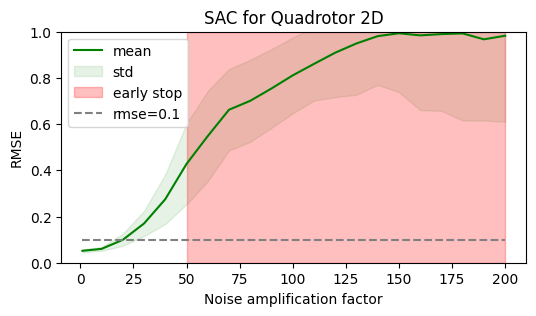

In [65]:
fig = plt.figure(figsize=(6, 3))
# for method in metric.keys():
method = 'SAC'
temp, temp_std1, temp_std2 = [], [], []
traj_success_till = 200
for ns in noise_scale:
    data = np.array(metric[method][ns]['rmse'])
    temp.append(data.mean())
    temp_std1.append(data.mean() - data.std())
    temp_std2.append(data.mean() + data.std())
    print(all(metric[method][ns]['success']))
    if not all(metric[method][ns]['success']) and traj_success_till > ns:
        traj_success_till = ns
plt.plot(noise_scale, temp, color=colors[method], label='mean')
plt.fill_between(noise_scale, 
                 temp_std1,  
                 temp_std2, color=colors[method], alpha=0.1, label='std')

plt.fill_between([traj_success_till, 200], [1, 1], color='r', alpha=0.25, label='early stop')
plt.plot(noise_scale, [0.1]*len(noise_scale), color='grey', linestyle='--', label='rmse=0.1')

plt.legend()
plt.ylim(0,1)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise amplification factor")
plt.ylabel("RMSE")
plt.title("SAC for Quadrotor 2D")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [66]:
np.save('compiled_metric.npy',metric, allow_pickle=True)

In [ ]:
eval_data = {}
fig = plt.figure()
for method in data_paths.keys():
    temp = np.zeros((len(seeds), 4, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        # temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["c"]
    eval_data.update({method: temp})

    # plotting
    plt.plot(temp[0,0,:], np.mean(temp[:,3,:], axis=0), label=method)
    # plt.fill_between(temp[0,0,:], np.mean(temp[:,1,:], axis=0)+np.mean(temp[:,2,:], axis=0)**.5, np.mean(temp[:,1,:], axis=0)-np.mean(temp[:,2,:], axis=0)**0.5, alpha=0.25)
plt.legend()
# plt.ylim(0,10)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("% Constraint violation")
plt.title("Task: Cartpole")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [ ]:
gp_05 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_0.5_constraint_percentage.npy", allow_pickle=True)
gp_10 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_1.0_constraint_percentage.npy", allow_pickle=True)
gp_30 = np.load(os.getcwd() + "/gp_mpc_data/gp_mpc_M_3.0_constraint_percentage.npy", allow_pickle=True)

gp_30.item()

In [ ]:
# data_paths = {"ppo_pyb": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/0", 
#              "ppo_sysid": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/1"}
data_paths = {"ppo_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Long_run", 
             "ppo_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Medium_run",
             "ppo_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_ppo_data/Short_run",
             "sac_1": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Long_run", 
             "sac_2": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Medium_run",
             "sac_3": os.getcwd()+"/Results/LSY_pc/quadrotor_2D_attitude_sac_data/Short_run",}

In [ ]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    if method != "ppo_4":
        perf_data.update({method: {}})
        xk, x, yk, y = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return_std.log")
        # xk, x1, yk, y1 = load_from_log_file(data_paths[method] + "/HW/" + "/logs/stat_eval/ep_return.log")
        # xk, x1, zk, z1 = load_from_log_file(data_paths[method] + "/HW/" + "/logs/stat_eval/ep_return_std.log")
        xk, x, yk, m = load_from_log_file(data_paths[method] + "/logs/stat_eval/mse.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({"x": x, "y": y, "z": z, "m": m})
    else:
        perf_data.update({method: {}})
        xk, x, yk, y = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + "/logs/stat_eval/ep_return_std.log")
        perf_data[method].update({"x": x, "y": y, "z": z})

In [ ]:
perf_data

In [ ]:
fig = plt.figure()
method = "ppo_1"
plt.plot(perf_data[method]["x"], perf_data[method]["y"], 'r', label=method)
# plt.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
last_iter1 = perf_data[method]["x"][-1]
last_iter = last_iter1
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'r')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)


method = "ppo_2"
start_iter = last_iter1 - perf_data[method]["x"][-1]
plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'g', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'g')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)


method = "ppo_3"
start_iter = last_iter1 - perf_data[method]["x"][-1]
plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x1"], perf_data[method]["y1"], 'b')
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)

method = "ppo_4"
# start_iter = last_iter1 - perf_data[method]["x"][-1]
# plt.plot(start_iter+perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
# plt.fill_between(start_iter+perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
#                      perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")
plt.plot(last_iter+perf_data[method]["x"], perf_data[method]["y"], 'm', label=method)
# plt.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
#                      perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)

plt.legend()
plt.ylim(00, 600)
plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("Cummulative return")
plt.title("Task: Quad_2d")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)

In [ ]:
ax1 = plt.subplot(3,1,1)
method = "ppo_1"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], 'b', label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

method = "ppo_2"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# ax1.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

method = "ppo_3"
ax1.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax1.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)
# last_iter = perf_data[method]["x"][-1]
# plt.plot([last_iter]*200, np.linspace(0, 600, 200), "--k")

ax2 = plt.subplot(3,3,1)
method = "ppo_1"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], 'b')
ax2.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_2"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], label=method)
ax2.fill_between(last_iter+perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_3"
ax2.plot(perf_data[method]["x1"], perf_data[method]["y1"], label=method)
ax2.fill_between(perf_data[method]["x1"], perf_data[method]["y1"]+perf_data[method]["z1"], 
                     perf_data[method]["y1"]-perf_data[method]["z1"], alpha=0.25)
method = "ppo_4"
ax2.plot(perf_data[method]["x"], perf_data[method]["y"], label=method)
ax2.fill_between(perf_data[method]["x"], perf_data[method]["y"]+perf_data[method]["z"], 
                     perf_data[method]["y"]-perf_data[method]["z"], alpha=0.25)

plt.legend()
plt.ylim(00, 600)
# plt.xscale("log")
plt.xlabel("Training steps")
plt.ylabel("Cummulative return")
plt.title("Task: Quad_2d")
# plt.savefig("perf1.pdf",bbox_inches="tight", pad_inches=0.0)